# Аналитика в Яндекс.Афише

## Описание проекта

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Необходимо изучить:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

### Оглавление:
- [Шаг 1. Загрузить данные и подготовить их к анализу](#step1)
- [Шаг 2. Построить отчёты и посчитать метрики](#step2)
    - [Продукт](#step3)
    - [Продажи](#step4)
    - [Маркетинг](#step5)
    - [Вывод](#step6)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

### Шаг 1. Загрузить данные и подготовить их к анализу <a id="step1"></a>

In [3]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [4]:
for df in (visits, orders, costs):
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [5]:
for df in (visits, orders, costs):
    display(df.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [6]:
for df in (visits, orders, costs):
    display(df.duplicated().sum())

0

0

0

In [7]:
visits['Source Id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

##### Вывод
1. Пропусков не наблюдается.
2. Все даты указаны в формате object, их необходимо будет преобразить в datetime64.
3. Названия столбцов приведем к нижнему регистру, а вместо пробелов между слов поставить нижнее подчеркивание.
4. Дубликатов нет.

In [8]:
# Приведем названия столбцов к нижнему регистру.

for df in (visits, orders, costs):
    df.columns = df.columns.str.lower()
    display(df.columns)

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

Index(['buy ts', 'revenue', 'uid'], dtype='object')

Index(['source_id', 'dt', 'costs'], dtype='object')

In [9]:
# Поменяем пробелы в названиях столбцов на нижнее подчеркивание.

visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']
display(visits.columns)
display(orders.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [10]:

visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

for df in (visits, orders, costs):
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


None

### Шаг 2. Построить отчёты и посчитать метрики<a id="step2"></a>

#### Продукт<a id="step3"></a>
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

##### Ответим на вопрос: сколько людей пользуются в день, неделю, месяц?

In [11]:
# Чтоб посчитать количество пользователей, выделим в отдельные столбцы день, месяц, год и дату.

visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits['date'] = pd.to_datetime(visits['date'])
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [12]:
# Сгруппируем данные по уникальным пользователям и найдём среднее

dau = visits.groupby('date').agg({'uid':'nunique'})
wau = visits.groupby(['year', 'week']).agg({'uid':'nunique'})
mau = visits.groupby(['year', 'month']).agg({'uid':'nunique'})
print('Пользователей в день:', int(dau.mean()))
print('Пользователей в неделю:', int(wau.mean()))
print('Пользователей в месяц:', int(mau.mean()))

Пользователей в день: 907
Пользователей в неделю: 5716
Пользователей в месяц: 23228


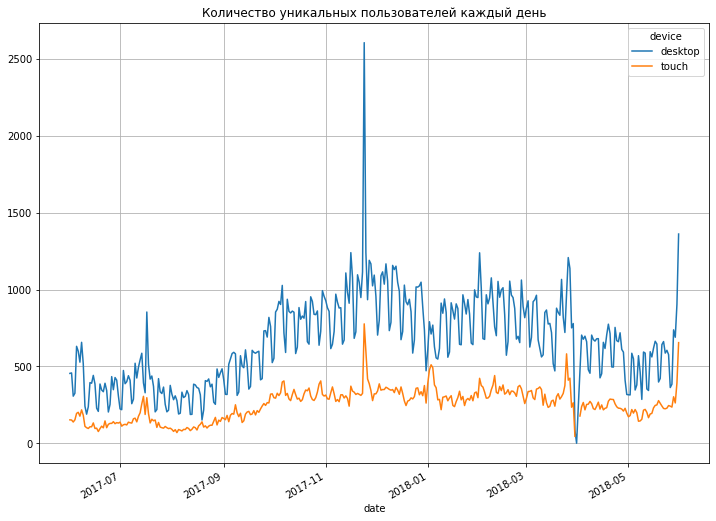

In [13]:
visits.pivot_table(index = 'date', 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize=(12, 9), 
                                             grid=True, 
                                             title='Количество уникальных пользователей каждый день') 

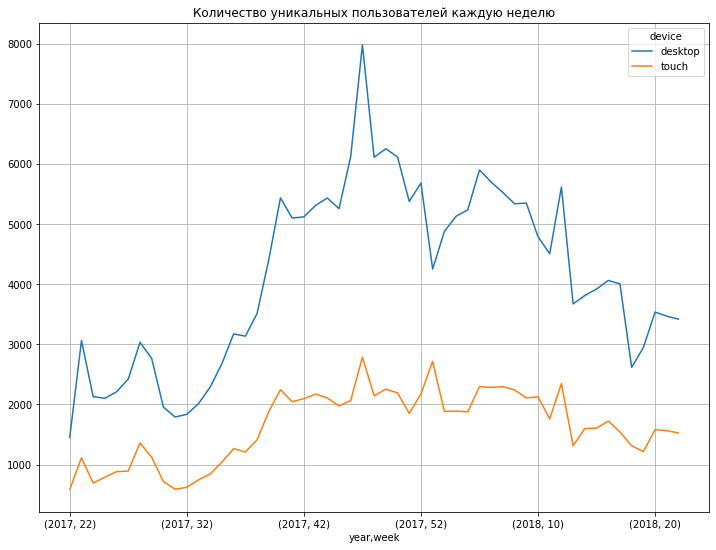

In [14]:
visits.pivot_table(index = ['year','week'], 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize=(12, 9), 
                                             grid=True, 
                                             title='Количество уникальных пользователей каждую неделю') 

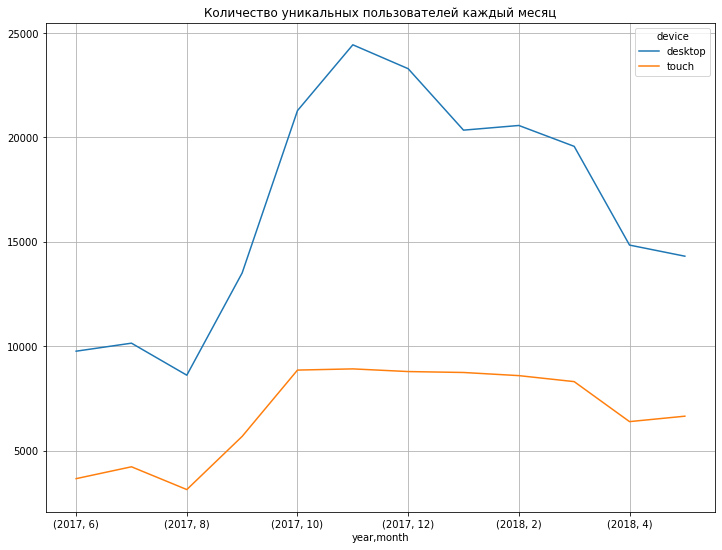

In [15]:
visits.pivot_table(index = ['year', 'month'], 
                   columns = 'device', 
                   values = 'uid', 
                   aggfunc = 'nunique').plot(figsize=(12, 9), 
                                             grid=True, 
                                             title='Количество уникальных пользователей каждый месяц') 

Значительно больше пользователей заходят с домашнего компьютера, нежели с мобильного устройства. Распределение пользователей по дням/неделям и месяцам примерно одинаковое на двух видах устройств.

На графике уникальных пользователей ежедневно видим сильный всплеск активности во второй половине ноября, как с ПК, так и с мобильных устройств. А в конце марта 2018 года сильное проседание по количеству пользователей с ПК. Возможно, в этот день были проблемы с веб версией сайта.

##### Посчитаем среднее количество сессий в день на одного пользователя. 
Для этого сгруппируем датасет по дате и найдем количество сессий и количество уникальных пользователей в день, затем поделим первый показатель на второй и найдем среднее значение.

In [16]:
sessions_per_user = visits.groupby('date').agg({'uid':['count', 'nunique']})
sessions_per_user.columns = ['num_sess', 'num_users']
sessions_per_user['sess_per_user'] = sessions_per_user['num_sess'] / sessions_per_user['num_users']
print('Среднее количество сессий в день:', sessions_per_user['sess_per_user'].mean())

Среднее количество сессий в день: 1.0821696440039723


##### Ответим на вопрос: сколько длится одна сессия?

In [17]:
visits['sess_duration'] = visits['end_ts'] - visits['start_ts']
visits['sess_duration'] = visits['sess_duration'].dt.seconds

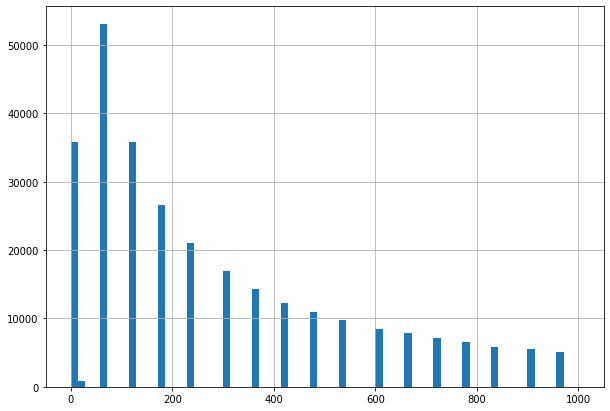

In [18]:
visits['sess_duration'].hist(bins=70, range=(0, 1000), figsize=(10, 7))

На гистограмме видим ненормальное распределение, поэтому сренее значение не подойдет, поэтому рассчитаем моду.

In [19]:
visits['sess_duration'].mode()

0    60
dtype: int64

##### Ответим на вопрос: как часто люди возвращаются на Яндекс.Афишу. 
Для этого возьмем дату первого посещения и добавим ее в основной датафрейм visits. Сформирируем когорты по данным за месяц.

In [20]:
first_activity_date = visits.groupby(['uid'])['date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date, on='uid')

visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,sess_duration,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27


In [21]:
# Выделим из столбцов start_ts и first_activity_date месяцы.

visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['end_ts'].astype('datetime64[M]')

# Теперь рассчитаем показатель lifetime для каждой когорты покупателей
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year,sess_duration,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440,2018-03-09,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0,2017-12-27,2017-12-01,2017-12-01,0


In [22]:
cohorts = (visits.groupby(['first_activity_month', 'cohort_lifetime'])
           .agg({'uid':'nunique'}).reset_index())
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13255,13255,1.000000
1,2017-06-01,1,1047,13255,0.078989
2,2017-06-01,2,713,13255,0.053791
3,2017-06-01,3,814,13255,0.061411
4,2017-06-01,4,909,13255,0.068578


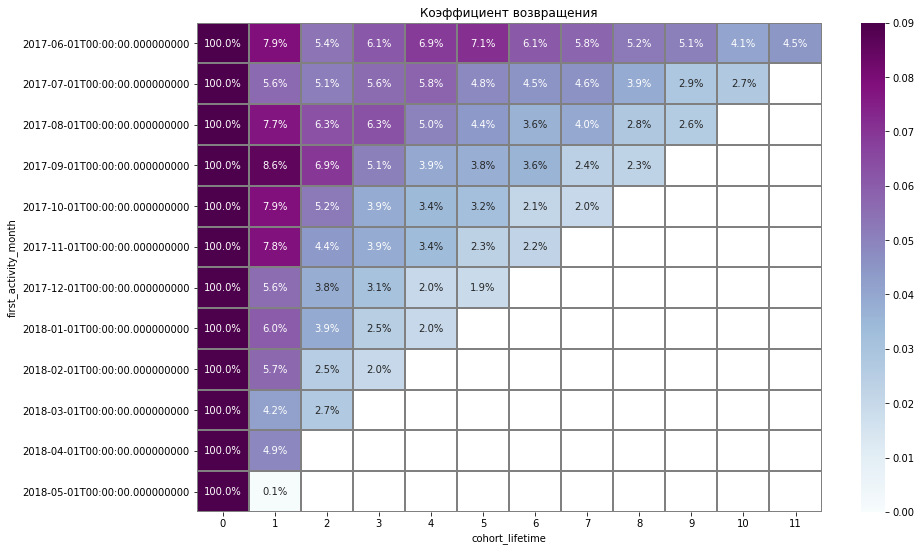

In [23]:
retention = cohorts.pivot_table(index='first_activity_month', 
                                columns='cohort_lifetime', 
                                values='retention', 
                                aggfunc='sum')
plt.figure(figsize=(14, 9))
plt.title('Коэффициент возвращения')
sns.heatmap(retention, 
            vmin=0,
            vmax=0.09,
            annot=True, 
            linewidths=1, 
            fmt='.1%', 
            linecolor='gray', 
            cmap='BuPu')

В первый месяц самый больше RR был у когорты 01-09-2017 (8,6%), но чем дальше, тем меньше оставалось клиентов. До последнего же месяца больше всего сохранилось клиентов из самой первой когорты 01-06-2017 - 4.5%, а на протяжении всех месяцев была самой стабильной.


#### Продажи <a id="step4"></a>
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

##### Ответим на вопрос: когда люди начинают покупать? 

In [24]:
# Для этого найдем самую раннюю дату начала сессии для каждого пользователя 
# и соединим с таблицей orders.

min_session_ts = visits.groupby(['uid'])['start_ts'].min()
min_session_ts.name = 'min_session_ts'
orders = orders.join(min_session_ts, on='uid')
orders['time_to_buy'] = orders['buy_ts'] - orders['min_session_ts']
orders['time_to_buy'] = orders['time_to_buy'].dt.seconds / 60
orders['time_to_buy'].mean()

358.04260636715264

In [25]:
first_order_date = orders.groupby(['uid'])['buy_ts'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date, on='uid')
orders.head(10)

,buy_ts,revenue,uid,min_session_ts,time_to_buy,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1.0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,11.0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2.0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,15.0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,27.0,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,0.0,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:51:00,3.0,2017-06-01 08:54:00
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,0.0,2017-06-01 09:22:00
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:18:00,4.0,2017-06-01 09:22:00
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:21:00,2.0,2017-06-01 09:23:00


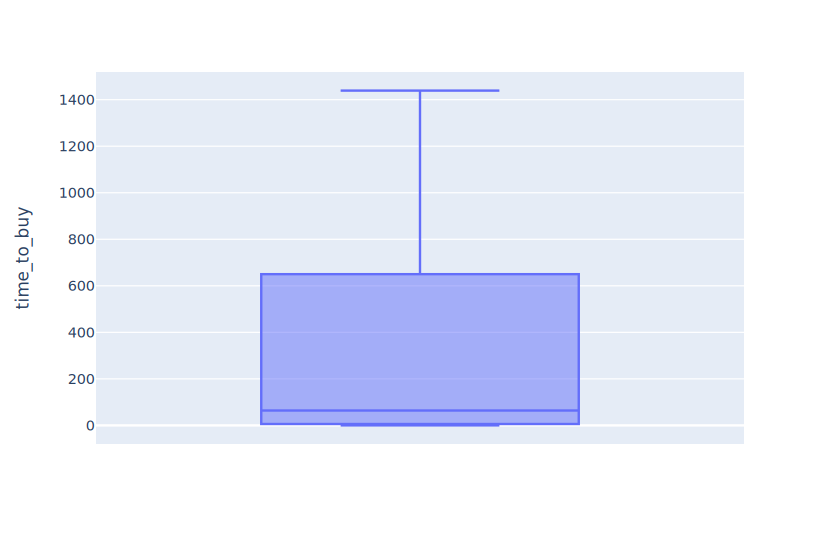

In [26]:
boxplt = px.box(orders, y='time_to_buy')
boxplt.show()

In [27]:
orders_query = orders.query('time_to_buy > 1000')
orders_query['time_to_buy'].value_counts()

1398.0    42
1434.0    42
1381.0    41
1412.0    41
1350.0    41
          ..
1049.0     7
1158.0     7
1086.0     7
1010.0     7
1028.0     3
Name: time_to_buy, Length: 439, dtype: int64

In [28]:
time_to_buy_mean = round(orders['time_to_buy'].mean(), 2)
print('Среднее время, через которое после начала сессии люди начинают покупать:', time_to_buy_mean)

Среднее время, через которое после начала сессии люди начинают покупать: 358.04


Не смотря на большую разницу между средним значением и медианой, в качестве ответа на этот вопрос мы возьмем среднее значение по столбцу ['time_to_buy']. В orders_query мы видим  439 строк с сессиями, которые длятся дольше 1000 секунд. На boxplot'е эти значения не являются выбросами, поэтому мы не стали их исключать.

##### Ответим на вопрос: сколько раз покупают за период. 
Для анализа рассмотрим количество покупок на одного пользователя в месяц и в неделю и посмотри на их графики.
Для этого в таблицу orders мы добавим столбец с неделей покупки. Для обоих вариантов мы:
- сгруппируем orders по первому месяцу покупки и месяцу покупки/недели покупки (в зависимости от периода) и найдем количество заказов и количество уникальных пользователей;
- поделим столбец с количеством заказов на количество уникальных пользователей;
- посмотрим графики.

In [29]:
orders.head()

,buy_ts,revenue,uid,min_session_ts,time_to_buy,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1.0,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,11.0,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2.0,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,15.0,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,27.0,2017-06-01 07:58:00


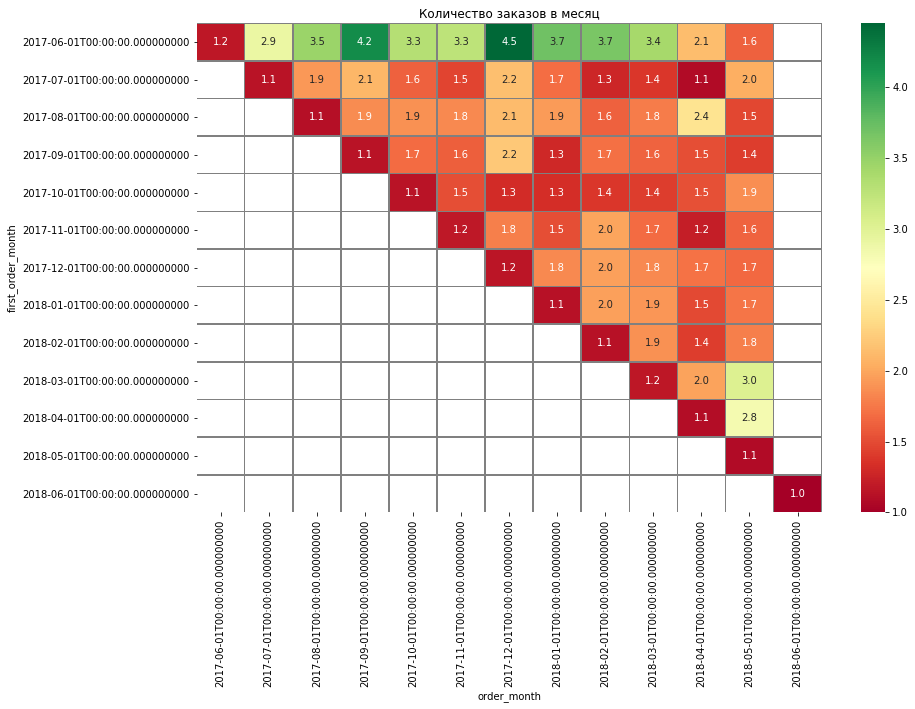

In [30]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')


orders_months = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'count', 'uid':'nunique'})
orders_months = orders_months.reset_index()
orders_months['orders_per_user'] = orders_months['revenue']/orders_months['uid']
orders_months_pivot = orders_months.pivot_table(index='first_order_month', 
                          columns='order_month', 
                          values='orders_per_user', 
                          aggfunc='mean')
plt.figure(figsize=(14, 9))
plt.title('Количество заказов в месяц')
sns.heatmap(orders_months_pivot, 
            annot=True, 
            fmt='.1F', 
            linewidth=0.5, 
            linecolor='grey', 
            cmap='RdYlGn')

In [31]:
orders['order_week'] = orders['buy_ts'].dt.week
orders_week = orders.groupby(['first_order_month', 'order_month', 'order_week']).agg({'revenue':'count', 'uid':'nunique'})
orders_week = orders_week.reset_index()
orders_week['orders_per_user'] = orders_week['revenue'] / orders_week['uid']
orders_week.head(15)

,first_order_month,order_month,order_week,revenue,uid,orders_per_user
0,2017-06-01,2017-06-01,22,340,295,1.152542
1,2017-06-01,2017-06-01,23,938,821,1.142509
2,2017-06-01,2017-06-01,24,343,317,1.082019
3,2017-06-01,2017-06-01,25,371,339,1.094395
4,2017-06-01,2017-06-01,26,362,325,1.113846
5,2017-06-01,2017-07-01,26,12,10,1.200000
6,2017-06-01,2017-07-01,27,42,18,2.333333
7,2017-06-01,2017-07-01,28,57,23,2.478261
8,2017-06-01,2017-07-01,29,39,21,1.857143
9,2017-06-01,2017-07-01,30,21,12,1.750000


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 <a list of 11 Text xticklabel objects>)

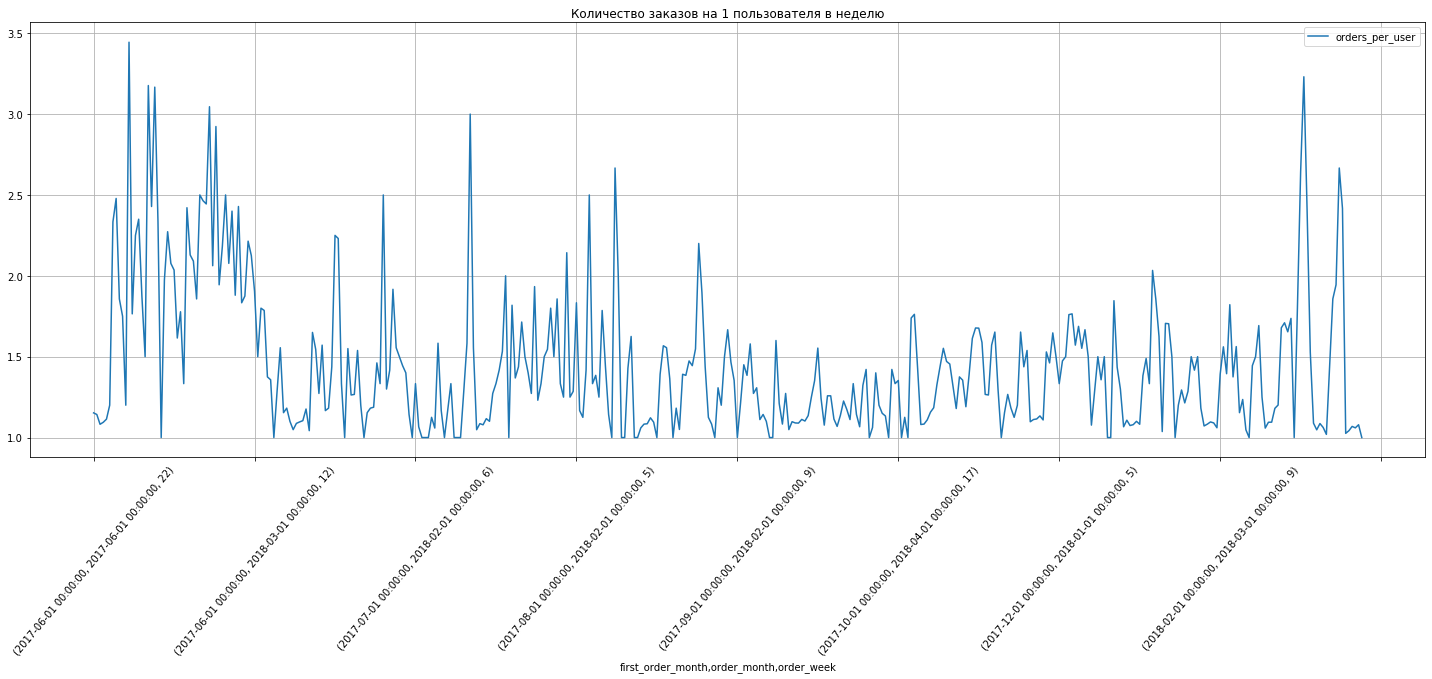

In [32]:
orders_week_pivot = orders_week.pivot_table(index=['first_order_month', 'order_month', 'order_week'], 
                                          values='orders_per_user', 
                                          aggfunc='mean').plot(figsize=(25, 8), 
                                                               grid=True, 
                                                               title='Количество заказов на 1 пользователя в неделю')
plt.xticks(rotation=50)

In [33]:
# Также отдельно найдем среднее количество покупок на одного пользователя в месяц и в неделю.

print('Среднее количество покупок на одного пользователя в месяц:', orders_months['orders_per_user'].mean())
print('Среднее количество покупок на одного пользователя в неделю:', orders_week['orders_per_user'].mean())

Среднее количество покупок на одного пользователя в месяц: 1.8589644143998318
Среднее количество покупок на одного пользователя в неделю: 1.4463938383455384


##### Ответим на вопрос: какой средний чек.

In [34]:
orders_by_cohorts = (orders.groupby(['first_order_month', 'order_month'])
                     .agg({'revenue':'sum', 'uid':'nunique'})).reset_index()
orders_by_cohorts['revenue_per_user'] = orders_by_cohorts['revenue'] / orders_by_cohorts['uid']
orders_by_cohorts.pivot_table(index='first_order_month', 
                                                    columns='order_month', 
                                                    values='revenue_per_user', 
                                                    aggfunc='mean')

order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_order_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


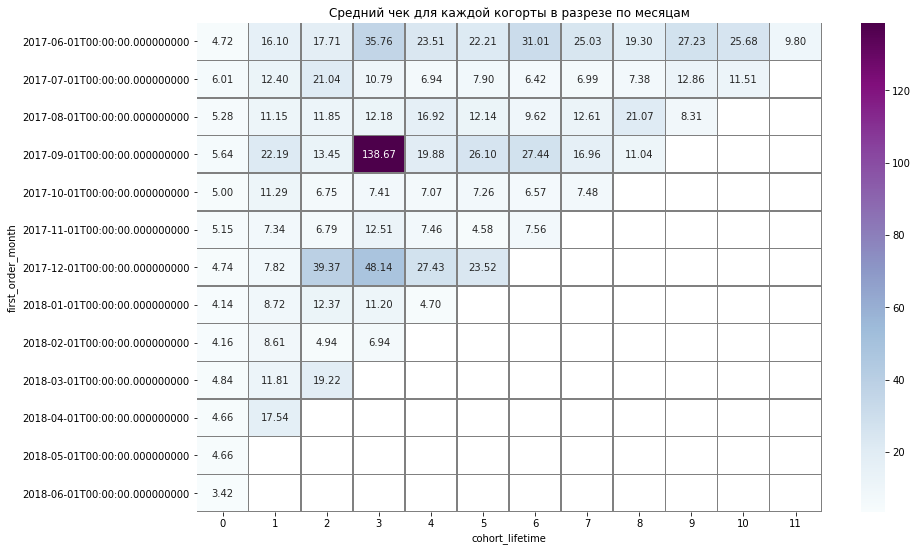

In [35]:
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['order_month'] - orders_by_cohorts['first_order_month']
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'] / np.timedelta64(1, 'M')
orders_by_cohorts['cohort_lifetime'] = orders_by_cohorts['cohort_lifetime'].round().astype('int')
average_check_pivot = orders_by_cohorts.pivot_table(index='first_order_month', 
                                                    columns='cohort_lifetime', 
                                                    values='revenue_per_user', 
                                                    aggfunc='mean')
plt.figure(figsize=(14, 9))
plt.title('Средний чек для каждой когорты в разрезе по месяцам')
sns.heatmap(average_check_pivot, 
            annot=True, 
            fmt='.2F', 
            linewidth=0.5, 
            linecolor='grey', 
            cmap='BuPu')

In [36]:
# Найдем средний чек для всех когорт в первый месяц, исключив при этом последнюю когорту.
# первый месяц у этой когорты еще не закончен, покупку совершил всего 1 клиент.

orders_by_cohorts_query = orders_by_cohorts.query('cohort_lifetime == 0 and first_order_month < "2018-06-01"')
print('Средний чек =', orders_by_cohorts_query['revenue_per_user'].mean())

Средний чек = 4.916822580277474


In [37]:
orders_by_cohorts_query

,first_order_month,order_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,4.724414,0
12,2017-07-01,2017-07-01,11557.65,1923,6.010218,0
23,2017-08-01,2017-08-01,7228.83,1370,5.276518,0
33,2017-09-01,2017-09-01,14568.53,2581,5.644529,0
42,2017-10-01,2017-10-01,21716.20,4340,5.003733,0
50,2017-11-01,2017-11-01,21036.26,4081,5.154683,0
57,2017-12-01,2017-12-01,20767.49,4383,4.738191,0
63,2018-01-01,2018-01-01,13949.50,3373,4.135636,0
68,2018-02-01,2018-02-01,15177.16,3651,4.156987,0
72,2018-03-01,2018-03-01,17095.49,3533,4.838803,0


- В каждой когорте в первый месяц срений чек был достаточно маленьким - не превышал отметки 6. Почти все когорты в последющие месяцы значительно наращивали его, за исключением когорты 2018-02-01. 
- Первая когорта поддерживала средний чек на отметке 20-35, но к последнему месяцу сдали свои позиции и опустились до 9.8.
- Самый высокий средний чек на последний месяц пока остается у когорты 2017-12-01.
- Резкий выбро видим на четвертом месяце у когорты 2017-09-01. Есть предположение, что сентябрьская когорта может быть связана с родителями детей, которые только пошли в школу. Для них 4й месяц - это декабрь - предновогодняя подготовка и поиск мероприятий на зимние новогодние каникулы.

##### Ответим на вопрос: сколько денег приносят (LTV).

- Получим первый месяц покупки каждого покупателя
- Затем посчитаем количество новых покупателей за каждый месяц.

In [38]:
first_orders = orders.groupby('uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_size = (first_orders
               .groupby('first_order_month')
               .agg({'uid':'nunique'}).reset_index())
cohort_size.columns = ['first_order_month', 'n_buyers']
cohort_size

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


- После посчитаем сколько каждая когорта в каждый месяц принесла прибыли. 
- К этой таблице добавим количество уникальых покупателей в месяц.

In [39]:
cohort_income = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohort_income_buyers = pd.merge(cohort_size, cohort_income, on='first_order_month')
cohort_income_buyers['lifetime'] = (cohort_income_buyers['order_month'] - cohort_income_buyers['first_order_month'])/np.timedelta64(1, 'M')
cohort_income_buyers['lifetime'] = cohort_income_buyers['lifetime'].round().astype('int')
cohort_income_buyers.head()

,first_order_month,n_buyers,order_month,revenue,lifetime
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Чтобы посчитать LTV нам необходимо знать валовую прибыль, которая равно маржинальность * выручки. Столбец с выручкой у нас есть, а маржинальность примем за 1. Соответственно Валовая прибыль = Выручка * 1, Валовая прибыль = выручка.

In [40]:
cohort_income_buyers.head()

,first_order_month,n_buyers,order_month,revenue,lifetime
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


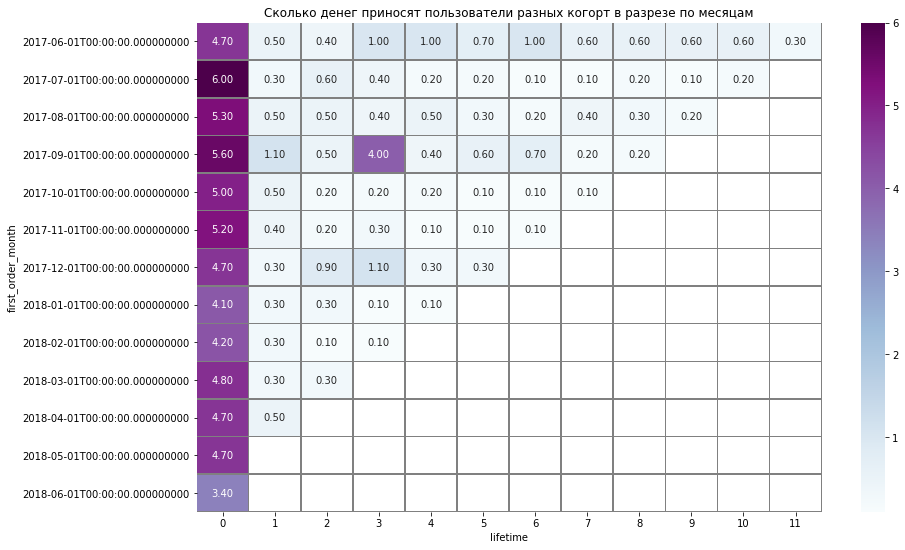

In [41]:
cohort_income_buyers['ltv'] = cohort_income_buyers['revenue'] / cohort_income_buyers['n_buyers']
ltv_pivot = cohort_income_buyers.pivot_table(index='first_order_month', 
                                             columns='lifetime', 
                                             values='ltv', 
                                             aggfunc='mean').round(1)
plt.figure(figsize=(14, 9))
plt.title('Сколько денег приносят пользователи разных когорт в разрезе по месяцам')
sns.heatmap(ltv_pivot, 
            annot=True, 
            fmt='.2F', 
            linewidth=0.5, 
            linecolor='grey', 
            cmap='BuPu')

In [42]:
# Найдем итоговый LTV первой когорты.

ltv_201706 = ltv_pivot.loc['2017-06-01'].sum()

ltv_201709 = ltv_pivot.loc['2017-09-01'].sum()
display(ltv_201709)
display(ltv_201706)

13.299999999999999

11.999999999999998

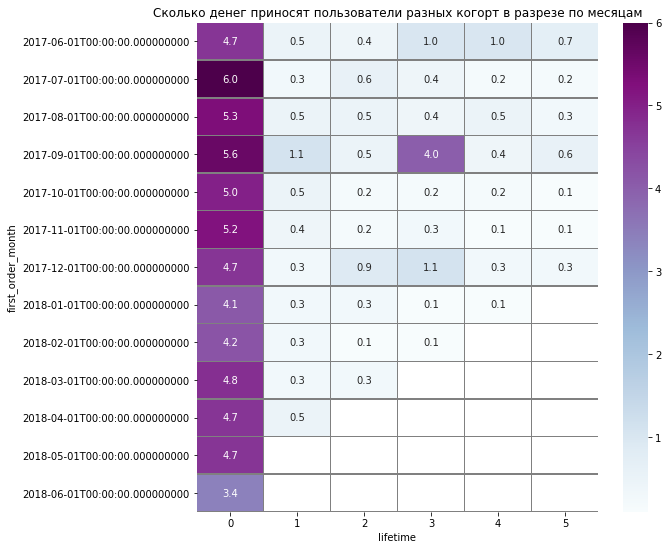

In [43]:
cohort_income_buyers['ltv'] = cohort_income_buyers['revenue'] / cohort_income_buyers['n_buyers']
ltv_pivot = cohort_income_buyers.query('lifetime < 6').pivot_table(index='first_order_month', 
                                             columns='lifetime', 
                                             values='ltv', 
                                             aggfunc='mean').round(1)

plt.figure(figsize=(9, 9))
plt.title('Сколько денег приносят пользователи разных когорт в разрезе по месяцам')
sns.heatmap(ltv_pivot, 
            annot=True, 
            fmt='.1F', 
            linewidth=0.5, 
            linecolor='grey', 
            cmap='BuPu')

In [44]:
# 
cohort_income_buyers_query = cohort_income_buyers.query('first_order_month < "2018-01-01" and lifetime < 6')
cohort_income_buyers_query.groupby('first_order_month').agg({'ltv':'sum'})

,ltv
first_order_month,
2017-06-01,8.360084
2017-07-01,7.660775
2017-08-01,7.375861
2017-09-01,12.306463
2017-10-01,6.159956
2017-11-01,6.280316
2017-12-01,7.639913


Самый высокий LTV у 4ой когорты 2017-09-01, у которой на четвертом месяце случился неожиданный ажиотаж в продажах, чего больше ни на одной когорте не наблюдалось. Возможно, в этой время проходила какая-нибудь акция, которая и увеличила продажи в одном месяце только.

#### Маркетинг <a id="step5"></a>
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

In [45]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


##### Ответим на вопрос: сколько денег потратили всего / на каждый источник / по времени

In [46]:
# Всего
costs_total = costs['costs'].sum()

# По источникам
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})

# По времени
costs_by_month = costs.groupby('month').agg({'costs':'sum'})

# От себя интересно посмотреть на распределение бюджета по источникам и месяцам
costs_by_month_source = costs.pivot_table(index='month', 
                                          columns='source_id', 
                                          values='costs', 
                                          aggfunc='sum')

print('Всего потратили', costs_total)
print('')
print('На каждый источник потратили', costs_by_source)
print('')
print('В каждом месяце потратили', costs_by_month)
display(costs_by_month_source.head(15))

Всего потратили 329131.62

На каждый источник потратили                costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49

В каждом месяце потратили                costs
month               
2017-06-01  18015.00
2017-07-01  18240.59
2017-08-01  14790.54
2017-09-01  24368.91
2017-10-01  36322.88
2017-11-01  37907.88
2017-12-01  38315.35
2018-01-01  33518.52
2018-02-01  32723.03
2018-03-01  30415.27
2018-04-01  22289.38
2018-05-01  22224.27


source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


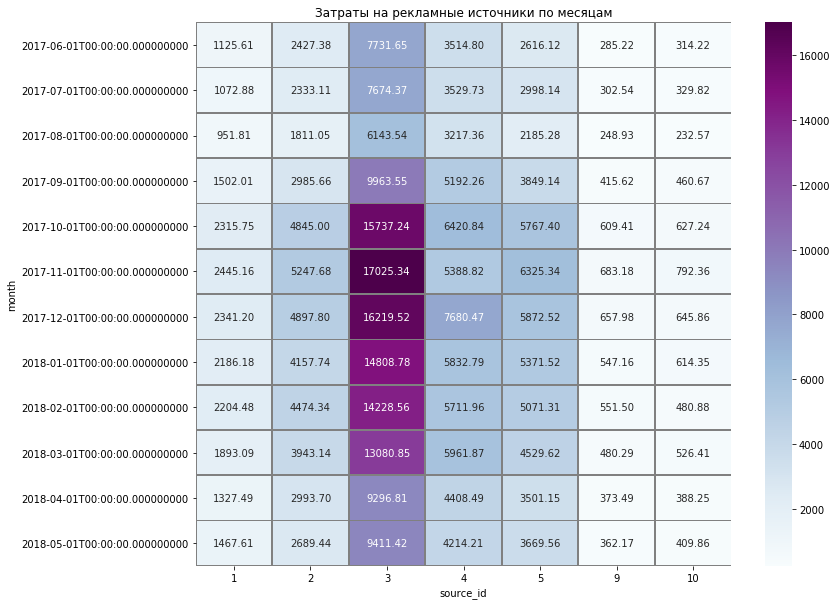

In [47]:
plt.figure(figsize=(12, 10))
plt.title('Затраты на рекламные источники по месяцам')
sns.heatmap(costs_by_month_source, 
            annot=True, 
            fmt='.2f', 
            linewidth=0.7, 
            linecolor='grey',
           cmap='BuPu')

Миниум бюджета в каждом месяце было выделено для источника №9 и 10. По остальных источников, видно, что больше бюджета выделялось в октябре, ноябре и декабре 2018 года, дальше с каждым месяцем бюджет уменьшался. Больше всего денег было потрачено на источник №3.

##### Ответим на вопрос: сколько стоило привлечение одного покупателя из каждого источника. 
Для этого необходимо:
- сгруппировать costs по месяцам и рекламным источникам и найти сумму затрат;
- сгруппировать пользователей по источникам и месяцам;
- соединить табличку costs и visits по источнику и месяцам;
- посчитать CAC.

In [48]:
for df in (visits, orders, costs):
    display(df.head(3))

,device,end_ts,source_id,start_ts,uid,date,week,month,year,sess_duration,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0,2017-07-01,2017-07-01,2017-07-01,0


,buy_ts,revenue,uid,min_session_ts,time_to_buy,first_order_date,order_month,first_order_month,order_week
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1.0,2017-06-01 00:10:00,2017-06-01,2017-06-01,22
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,11.0,2017-06-01 00:25:00,2017-06-01,2017-06-01,22
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2.0,2017-06-01 00:27:00,2017-06-01,2017-06-01,22


,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01


In [49]:
visits_first_source = visits.groupby(['first_activity_month','uid']).agg({'source_id': 'first'}).reset_index()
orders_with_source = orders.merge(visits_first_source, 
                                  left_on=('first_order_month', 'uid'), 
                                  right_on=('first_activity_month', 'uid'))
orders_with_source.head()

,buy_ts,revenue,uid,min_session_ts,time_to_buy,first_order_date,order_month,first_order_month,order_week,first_activity_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1.0,2017-06-01 00:10:00,2017-06-01,2017-06-01,22,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,11.0,2017-06-01 00:25:00,2017-06-01,2017-06-01,22,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2.0,2017-06-01 00:27:00,2017-06-01,2017-06-01,22,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,15.0,2017-06-01 00:29:00,2017-06-01,2017-06-01,22,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,27.0,2017-06-01 07:58:00,2017-06-01,2017-06-01,22,2017-06-01,3


In [50]:
orders_first_source = (orders_with_source.
                       groupby(['first_activity_month','uid']).
                       agg({'source_id': 'first'}).
                       reset_index())
orders_first_source

,first_activity_month,uid,source_id
0,2017-06-01,1575281904278712,10
1,2017-06-01,16233238570251706,3
2,2017-06-01,29085576454138824,5
3,2017-06-01,31782048561502182,3
4,2017-06-01,50884319066603964,3
...,...,...,...
30082,2018-05-01,18413403606138337462,4
30083,2018-05-01,18417227789295707563,5
30084,2018-05-01,18418973552381796231,2
30085,2018-05-01,18419772037216346332,3


In [51]:
# Найдем количество расходов в разбивке по месяцу и источнику.
costs_grouped = costs.groupby(['month', 'source_id']).agg({'costs':'sum'}).reset_index()
display(costs_grouped)

# Найдем какое количество покупателей приходило каждый месяц из каждого источника
orders_first_source = (orders_with_source.
                       groupby(['first_activity_month','uid']).
                       agg({'source_id': 'first'}).
                       reset_index())

orders_first_source_grouped = (orders_first_source.
                               groupby(['first_activity_month', 'source_id']).
                               agg({'uid':'count'}).
                               reset_index())
display(orders_first_source_grouped)

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


,first_activity_month,source_id,uid
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368
...,...,...,...
80,2018-05-01,3,592
81,2018-05-01,4,580
82,2018-05-01,5,418
83,2018-05-01,9,30


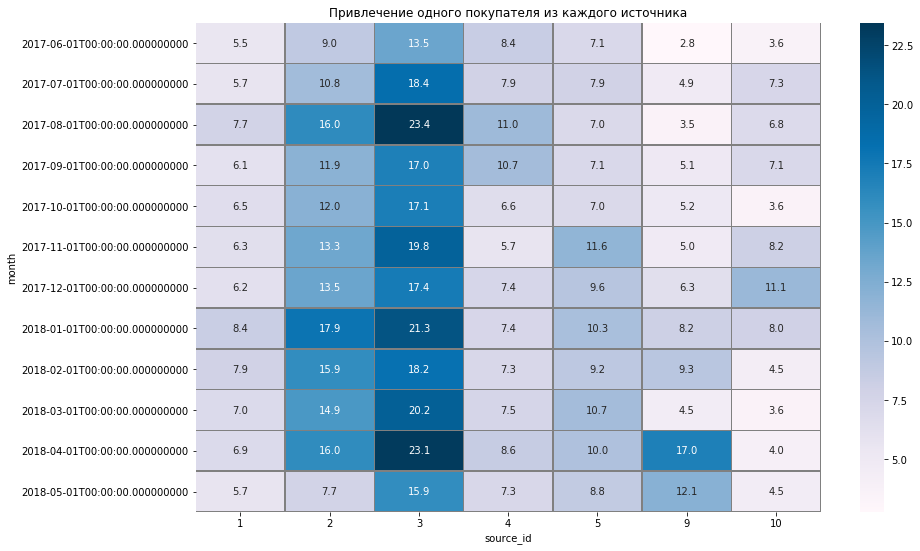

In [52]:
# Объединим две полученные таблички по полям 'month' и 'source_id'.

costs_buyers = orders_first_source_grouped.merge(costs_grouped, 
                                                 left_on=('first_activity_month', 'source_id'), 
                                                 right_on=('month', 'source_id'))

costs_buyers['cac'] = costs_buyers['costs'] / costs_buyers['uid']
costs_buyers_pivot = costs_buyers.pivot_table(index='month', 
                                              columns='source_id', 
                                              values='cac', 
                                              aggfunc='mean').round(2)
plt.figure(figsize=(14, 9))
plt.title('Привлечение одного покупателя из каждого источника')
sns.heatmap(costs_buyers_pivot, 
            annot=True, 
            fmt='.1f', 
            linewidth=0.5, 
            linecolor='gray', 
            cmap='PuBu')

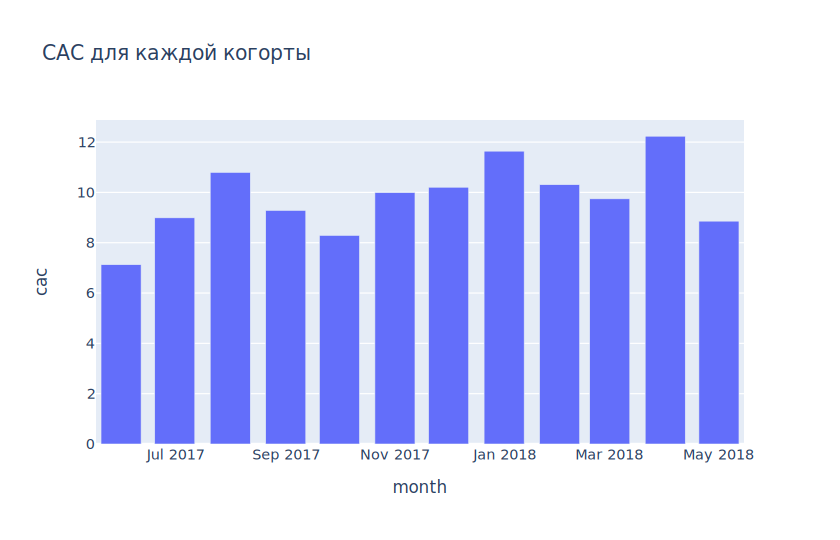

In [53]:
costs_buyers_pivot_new = costs_buyers.pivot_table(index='month',
                                                  values='cac',
                                                  aggfunc='mean').reset_index()
fig = px.bar(costs_buyers_pivot_new, x='month', y='cac', title='CAC для каждой когорты')
fig.show()

##### Ответим на вопрос: на сколько окупились расходы?

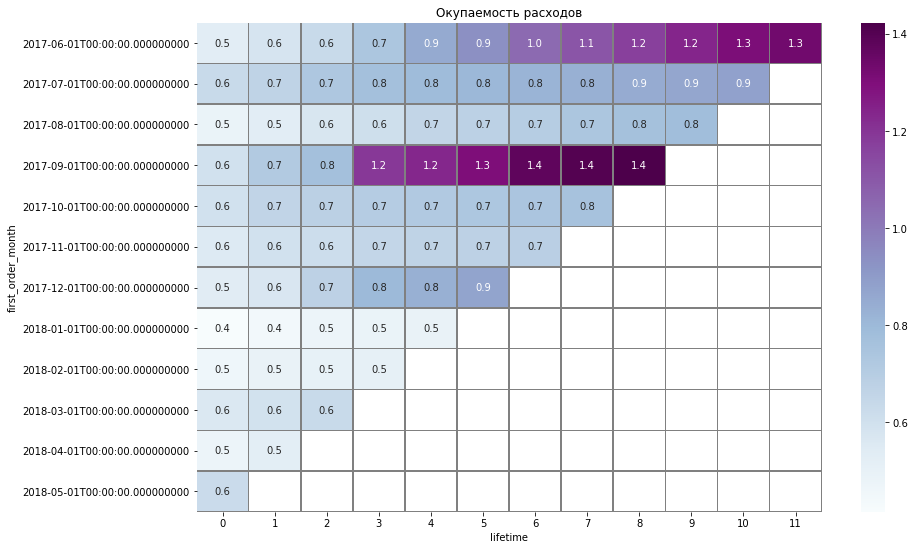

In [54]:
costs_month = costs.groupby('month').agg({'costs':'sum'}).reset_index()
costs_month.columns = ['first_order_month', 'costs']
all_mertics = pd.merge(cohort_income_buyers, costs_month, on='first_order_month', how='left')
all_mertics['cac'] = all_mertics['costs'] / all_mertics['n_buyers']
all_mertics['roi'] = all_mertics['ltv'] / all_mertics['cac']
output = all_mertics.pivot_table(index='first_order_month', 
                                 columns='lifetime', 
                                 values='roi', 
                                 aggfunc='mean')

output_new = output.cumsum(axis=1)
plt.figure(figsize=(14, 9))
plt.title('Окупаемость расходов')
sns.heatmap(output_new, 
            annot=True, 
            fmt='.1f', 
            linewidth=0.5, 
            linecolor='grey', 
            cmap='BuPu')

Чтобы найти ROMI по источникам, нам необходимо знать CAC по источником и LTV по источникам. CAC уже посчитан в табличке <b>costs_buyers</b>

Теперь нам нужно найти LTV по источникам. Для этого необходимо:
- ранее к табличке orders была присоединена колонка с источником, соответственно мы можем сгруппировать эту табличку по когорте, возрасту когорты и источнику и найти суммарную выручку (revenue);
- объединить табличку с выручкой и <b>costs_buyers</b> (где ранее посчитали количество пользователей, затраты и CAC для каждой когорте из каждого источника);
- ранее мы принимали валовую прибыль за выручку, так как маржинальность приравняли к 1 (Валовая прибыль = Выручка * 1);
- посчитаем LTV;
- посчитаем ROMI;
- построим графики.

In [55]:
costs_buyers.columns = ['first_order_month', 'source_id', 'uid', 'month', 'costs', 'cac']
display(costs_buyers)
orders_first_source_grouped.columns = ['first_order_month', 'source_id', 'uid']
display(orders_first_source_grouped)

,first_order_month,source_id,uid,month,costs,cac
0,2017-06-01,1,203,2017-06-01,1125.61,5.544877
1,2017-06-01,2,271,2017-06-01,2427.38,8.957122
2,2017-06-01,3,574,2017-06-01,7731.65,13.469774
3,2017-06-01,4,417,2017-06-01,3514.80,8.428777
4,2017-06-01,5,368,2017-06-01,2616.12,7.109022
...,...,...,...,...,...,...
79,2018-05-01,3,592,2018-05-01,9411.42,15.897669
80,2018-05-01,4,580,2018-05-01,4214.21,7.265879
81,2018-05-01,5,418,2018-05-01,3669.56,8.778852
82,2018-05-01,9,30,2018-05-01,362.17,12.072333


,first_order_month,source_id,uid
0,2017-06-01,1,203
1,2017-06-01,2,271
2,2017-06-01,3,574
3,2017-06-01,4,417
4,2017-06-01,5,368
...,...,...,...
80,2018-05-01,3,592
81,2018-05-01,4,580
82,2018-05-01,5,418
83,2018-05-01,9,30


In [56]:
#visitors_source = visits.groupby('uid').agg({'source_id':'first'})
#orders_with_source = orders.merge(visitors_source, on='uid')
orders_with_source['age'] = (orders_with_source['order_month'] - orders_with_source['first_order_month'])/np.timedelta64(1, 'M')
orders_with_source['age'] = orders_with_source['age'].round().astype('int')
display(orders_with_source.head())

,buy_ts,revenue,uid,min_session_ts,time_to_buy,first_order_date,order_month,first_order_month,order_week,first_activity_month,source_id,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,1.0,2017-06-01 00:10:00,2017-06-01,2017-06-01,22,2017-06-01,1,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,11.0,2017-06-01 00:25:00,2017-06-01,2017-06-01,22,2017-06-01,2,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2.0,2017-06-01 00:27:00,2017-06-01,2017-06-01,22,2017-06-01,2,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,15.0,2017-06-01 00:29:00,2017-06-01,2017-06-01,22,2017-06-01,2,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,27.0,2017-06-01 07:58:00,2017-06-01,2017-06-01,22,2017-06-01,3,0


In [57]:
orders_with_sources_grouped = (orders_with_source.
                               groupby(['first_order_month', 'age', 'source_id']).
                               agg({'revenue':'sum'}).
                              reset_index())
display(orders_with_sources_grouped['source_id'].value_counts())
display(orders_with_sources_grouped)
display(costs_buyers)

5     78
4     78
3     78
2     78
1     75
9     73
10    45
7      1
Name: source_id, dtype: int64

,first_order_month,age,source_id,revenue
0,2017-06-01,0,1,1168.45
1,2017-06-01,0,2,1551.76
2,2017-06-01,0,3,2466.71
3,2017-06-01,0,4,2039.64
4,2017-06-01,0,5,1787.68
...,...,...,...,...
501,2018-05-01,0,3,2114.49
502,2018-05-01,0,4,2378.16
503,2018-05-01,0,5,1712.07
504,2018-05-01,0,9,101.09


,first_order_month,source_id,uid,month,costs,cac
0,2017-06-01,1,203,2017-06-01,1125.61,5.544877
1,2017-06-01,2,271,2017-06-01,2427.38,8.957122
2,2017-06-01,3,574,2017-06-01,7731.65,13.469774
3,2017-06-01,4,417,2017-06-01,3514.80,8.428777
4,2017-06-01,5,368,2017-06-01,2616.12,7.109022
...,...,...,...,...,...,...
79,2018-05-01,3,592,2018-05-01,9411.42,15.897669
80,2018-05-01,4,580,2018-05-01,4214.21,7.265879
81,2018-05-01,5,418,2018-05-01,3669.56,8.778852
82,2018-05-01,9,30,2018-05-01,362.17,12.072333


Мы имеем таблички:
- costs_buyers с количеством пользователей, расходами (costs) и CAC по источникам и когортам;
- orders_with_sources_grouped с выручкой (revenue).

Теперь мы можем соединить эти таблички, чтобы найти LTV и ROMI по когортам и источникам.

In [58]:
report = costs_buyers.merge(orders_with_sources_grouped, on=('first_order_month', 'source_id'))
report
report['ltv'] = report['revenue']/report['uid']
report['romi'] = report['ltv']/report['cac']
report

,first_order_month,source_id,uid,month,costs,cac,age,revenue,ltv,romi
0,2017-06-01,1,203,2017-06-01,1125.61,5.544877,0,1168.45,5.755911,1.038059
1,2017-06-01,1,203,2017-06-01,1125.61,5.544877,1,362.94,1.787882,0.322439
2,2017-06-01,1,203,2017-06-01,1125.61,5.544877,2,153.72,0.757241,0.136566
3,2017-06-01,1,203,2017-06-01,1125.61,5.544877,3,695.88,3.427980,0.618225
4,2017-06-01,1,203,2017-06-01,1125.61,5.544877,4,760.74,3.747488,0.675847
...,...,...,...,...,...,...,...,...,...,...
500,2018-05-01,3,592,2018-05-01,9411.42,15.897669,0,2114.49,3.571774,0.224673
501,2018-05-01,4,580,2018-05-01,4214.21,7.265879,0,2378.16,4.100276,0.564319
502,2018-05-01,5,418,2018-05-01,3669.56,8.778852,0,1712.07,4.095861,0.466560
503,2018-05-01,9,30,2018-05-01,362.17,12.072333,0,101.09,3.369667,0.279123


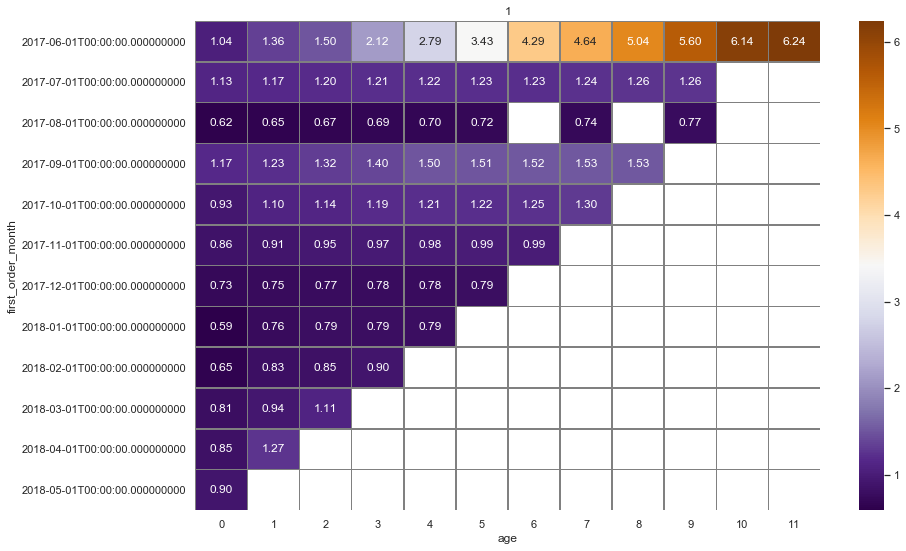

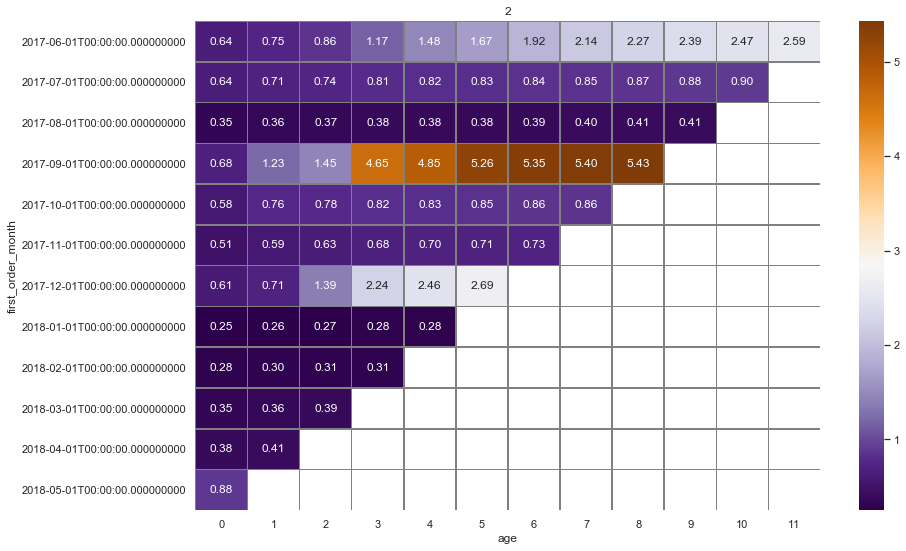

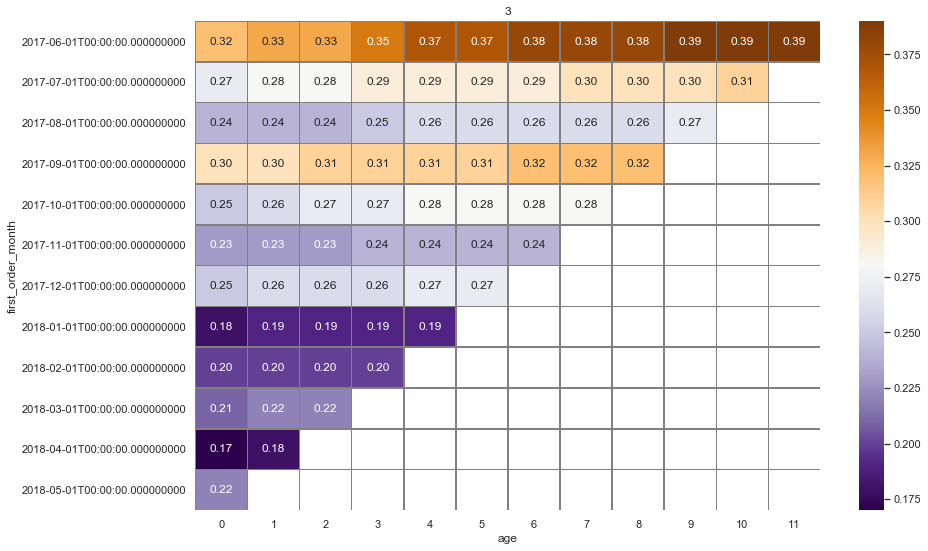

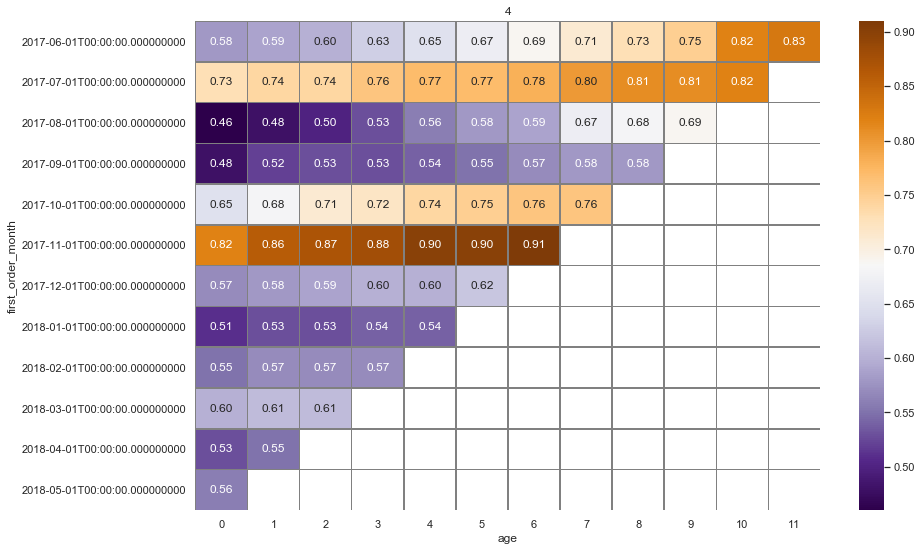

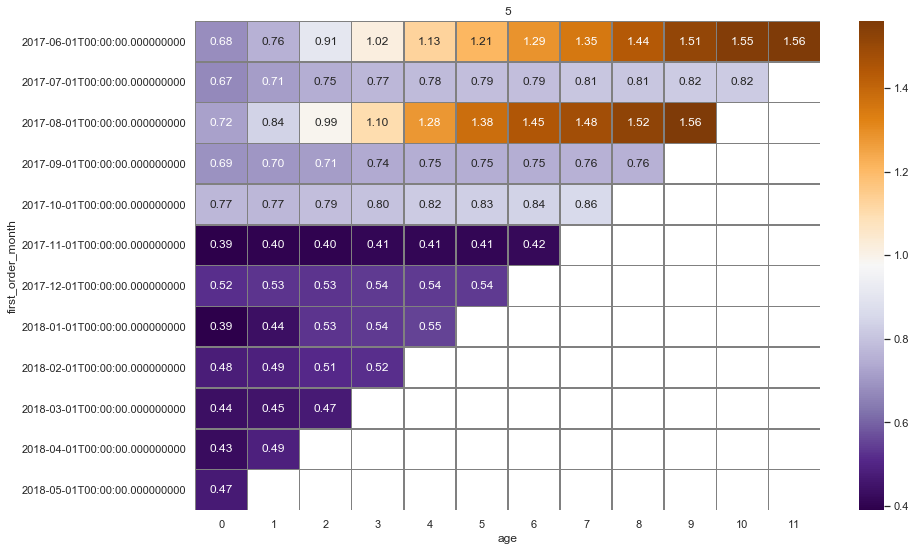

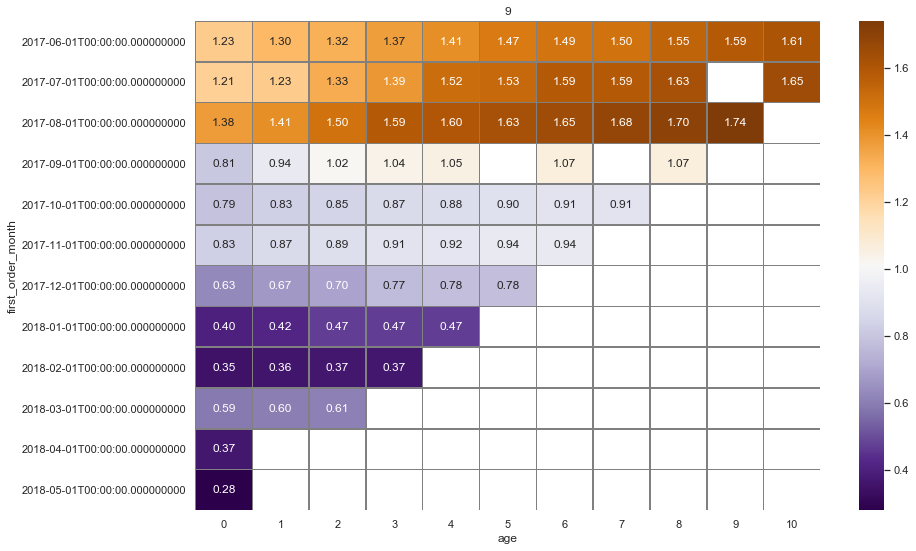

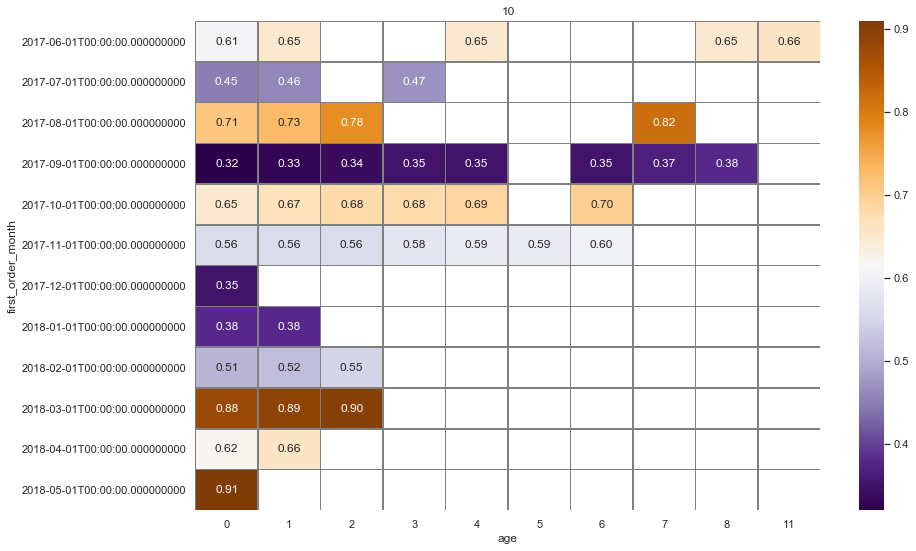

In [59]:
for source in report.source_id.unique():
        report_pivot = report.query('source_id == @source').pivot_table(
        index='first_order_month',
        columns='age',
        values='romi',
        aggfunc='mean')
        report_pivot_new = report_pivot.cumsum(axis=1).round(2)
        
        plt.figure(figsize=(14, 9))
        sns.set(style='white')
        plt.title(source)
        sns.heatmap(report_pivot_new, 
                    annot=True, 
                    fmt='.2f', 
                    linewidth=0.5, 
                    linecolor='grey', 
                    cmap='PuOr_r')

### Вывод: <a id="step6"></a>
- На графиках показателей DAU, WAU и MAU мы увидели, что большее число посетилетей заходят на Яндекс.Афишу через персональные компьютеры, гораздо меньше посетителей, которые заходят через моибльные устройства. Стоит это принять в сведению!
------------------------------------------------------------------------------
- Процент возвращающихся клиентов на сайт за покупками очень мал. Самый высокий процент во второй месяц был у когорты 2018-09-01 (8.6%), дальше он стремительно падает. Самый высокий RR на последний месяц - у первой когорты 2017-06-01 - 4.5%. Стоит задуматься над тем, что мы можем cltkfnm, чтобы наши пользователи возращались к нам.
------------------------------------------------------------------------------ 
- В среднем люди начинают покупать примерно через чаc после начала сессии.
------------------------------------------------------------------------------
- Среднее количество покупок на одного пользователя в месяц: 1.86
- Среднее количество покупок на одного пользователя в неделю: 1.45
------------------------------------------------------------------------------
- Средний чек различается по когортам. Средний чек месяца, когда были выгружены данные, варьируется от 4.7 (когорта 2018-01-01) до 23.52 (когорта 2017-12-01). Если говорить про все месяцы, то мы увидим выброс у когорты в декабре. Есть предположение, что это связано приближением новогодних каникул (детские мероприятия, елки, театры, цирки, концерты).
- Средний чек = 14.878613335688678
------------------------------------------------------------------------------
- Источники 3, 4, 5 и 10 окупаются тяжелее всего, пока они медленнее всего движутся к своим целям.
------------------------------------------------------------------------------
- Рекламные источники. Самым затратным рекламным источником стал №3, меньше всего затрачено на источники №9 и 10 причем сразу по всем месяцам.
------------------------------------------------------------------------------
- Сразу же хочется сказать про стоимость привлечения одного клиента по источникам (CAC). Самым дорогим (минимум в три раза относительно остальных) клиентом стал клиент из источника №3. Скорее всего количество клиентов из этого источника примерно такое же, как из остальных, при этом стоимость привлечения из-за этого сильно выше по сравнению с остальными каналами. Возможно, стоит уменьшим бюджетирование этого источника, попробовать вложить либо в один другой источник, либо распределить на несколько.